Enter ingredients:  pepperoni, sausage, olives, tomato sauce, cheese


{'name': 'Pepperoni Pizza', 'ingredients': ['pepperoni', 'olives', 'tomato sauce', 'cheese'], 'instructions': ['Preheat oven to 450°F', 'Spread tomato sauce on pizza dough', 'Top with cheese, pepperoni and olives', 'Bake for 12-15 minutes until cheese is melted and crust is golden brown'], 'cooking_time': 15, 'difficulty': 'easy'}
Pepperoni Pizza
A professional food photography shot of Pepperoni Pizza, on a white plate with garnish, studio lighting


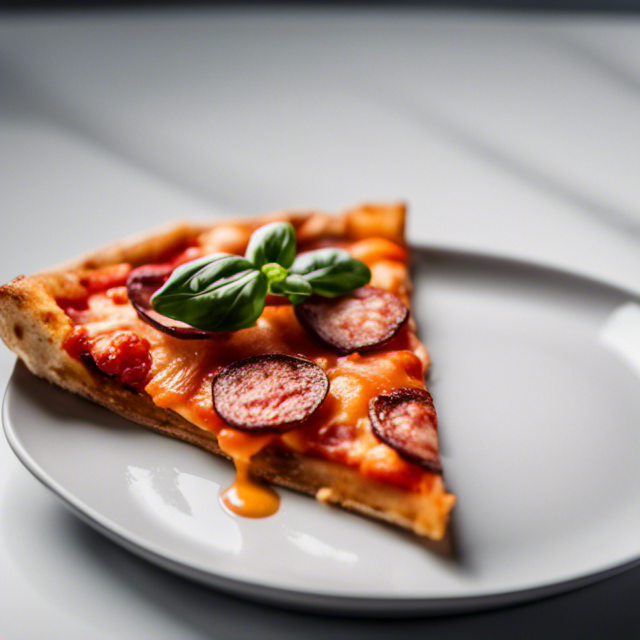

In [3]:
import boto3
import json
import re
import random
import base64
from PIL import Image
import io
import logging
from IPython.display import Image as IPImage
from IPython.display import display, HTML

class RecipeGenerator:
    def __init__(self):
        self.bedrock = boto3.client('bedrock-runtime')


    def extract_json(self, response):
        # Find JSON content between triple backticks
        json_match = re.search(r'```json\n(.*?)\n```', response['completion'], re.DOTALL)
        if json_match:
            return json.loads(json_match.group(1))
        return None
    
    
    def generate_recipe(self, ingredients):
        prompt = f"""\nHuman:\n\nCreate a recipe using these ingredients: {', '.join(ingredients)}. 
        Format as JSON with fields: name, ingredients (list), instructions (list), cooking_time (minutes), difficulty
        \nAssistant:\n"""
        
        response = self.bedrock.invoke_model(
            modelId='anthropic.claude-v2',
            body=json.dumps({
                "prompt": prompt,
                "max_tokens_to_sample": 500,
                "temperature": 0.7
            })
        )
        
        recipe = self.extract_json(json.loads(response['body'].read()))
        
        print(recipe)
        return recipe

    def generate_image(self, recipe_name):
        print(f"{recipe_name}")
        prompt = f"A professional food photography shot of {recipe_name}, on a white plate with garnish, studio lighting"
        print(prompt)
        
        seed = random.randint(0, 4294967295)
        # client =  boto3.client('bedrock-runtime',region_name="us-west-2")
        
        response = self.bedrock.invoke_model(
            modelId='stability.stable-diffusion-xl-v1',
            body=json.dumps({
                "text_prompts": [{"text": prompt}],
                "style_preset": "photographic",
                "seed": seed,
                "height": 640,
                "width": 640,
                "cfg_scale": 7,
                "steps": 50,
            })
        )

        model_response = json.loads(response["body"].read())
        base64_image_data = model_response["artifacts"][0]["base64"]
        image_data = base64.b64decode(base64_image_data)
        return Image.open(io.BytesIO(image_data))

    def display_recipe(self, recipe, image):
        html = f"""
        <div style='max-width: 800px; margin: 20px auto; font-family: Arial;'>
            <h1>{recipe['name']}</h1>
            <div style='margin: 20px 0;'>
                <h3>Ingredients:</h3>
                <ul>
                    {''.join(f'<li>{ingredient}</li>' for ingredient in recipe['ingredients'])}
                </ul>
            </div>
            <div style='margin: 20px 0;'>
                <h3>Instructions:</h3>
                <ol>
                    {''.join(f'<li>{instruction}</li>' for instruction in recipe['instructions'])}
                </ol>
            </div>
            <div>
                <p>Cooking Time: {recipe['cooking_time']} minutes</p>
                <p>Difficulty: {recipe['difficulty']}</p>
            </div>
        </div>
        """
        display(HTML(html))
        display(image)

generator = RecipeGenerator()
ingredients = input('Enter ingredients: ')
# ingredients = "eggs, mustard, mayo, relish"
recipe = generator.generate_recipe(ingredients)
image = generator.generate_image(recipe['name'])
generator.display_recipe(recipe, image)
